# **Assignment** **- Forecasting** 

Forecast the CocaCola prices and Airlines Passengers data set. Prepare a document for each model explaining 

how many dummy variables you have created and RMSE value for each model. 

Finally which model you will use for 
Forecasting.

**Data:** Airlines Data, CocaCola_sales

## **Importing Necessary Libraries**

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

import warnings
warnings.filterwarnings('ignore')

##**Importing Data**

In [124]:
Airline_data = pd.read_excel('Airlines+Data.xlsx')
Airline_data

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [125]:
# Parse strings to datetime type
Airline_data['Month'] = pd.to_datetime(Airline_data['Month'], infer_datetime_format=True)
indexedDataset = Airline_data.set_index(['Month'])
indexedDataset 

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


In [126]:
from datetime import datetime
indexedDataset['1995-03']
indexedDataset['1995-03':'1995-06']
indexedDataset['1995']

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
1995-06-01,135
1995-07-01,148
1995-08-01,148
1995-09-01,136


In [127]:
indexedDataset .shape

(96, 1)

In [128]:
indexedDataset .isna().sum()

Passengers    0
dtype: int64

In [129]:
indexedDataset.dtypes

Passengers    int64
dtype: object

In [130]:
type(indexedDataset )

pandas.core.frame.DataFrame

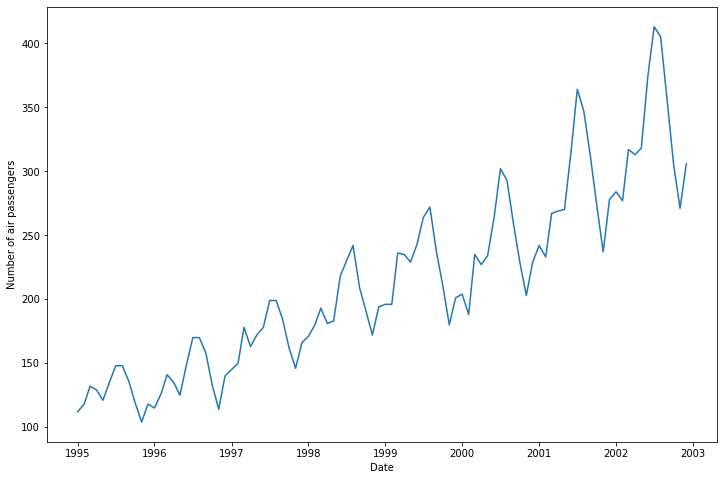

In [131]:
plt.figure(figsize=(12,8))
plt.xlabel("Date")
plt.ylabel("Number of air passengers")
plt.plot(indexedDataset)
plt.show()

In [132]:
#Determing rolling statistics
rolmean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean, rolstd)

            Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01  316.833333
2002-09-01  320.416667
2002-10-01  323.083333
2002-11-01  325.916667
2002-12-01  328.250000

[96 rows x 1 columns]             Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01   54.530781
2002-09-01   55.586883
2002-10-01   53.899668
2002-11-01   49.692616
2002-12-01   47.861780

[96 rows x 1 columns]


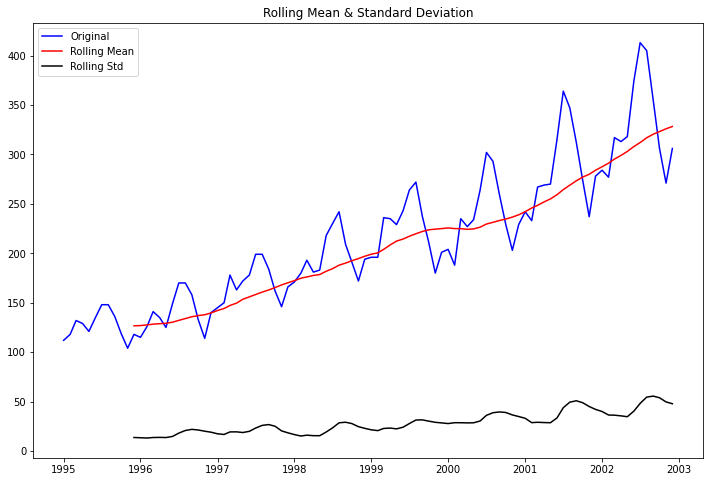

In [133]:
#Plot rolling statistics:
plt.figure(figsize=(12,8))
orig = plt.plot(indexedDataset, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [134]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


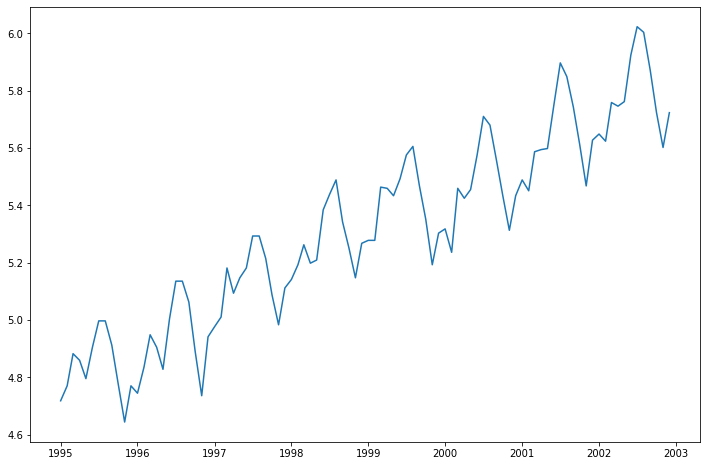

In [135]:
# Estimating trend
plt.figure(figsize=(12,8))
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)
plt.show()

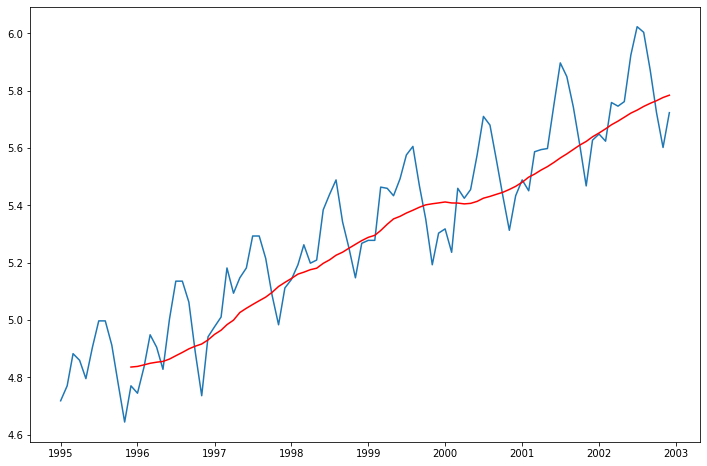

In [136]:
plt.figure(figsize=(12,8))
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')
plt.show()

In [137]:
# Get the difference between the moving average and the actual number of passengers
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)
#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Passengers
Month,
1995-12-01,-0.065494
1996-01-01,-0.093449
1996-02-01,-0.007566
1996-03-01,0.099416
1996-04-01,0.052142
1996-05-01,-0.027529
1996-06-01,0.139881
1996-07-01,0.260184
1996-08-01,0.248635


In [138]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

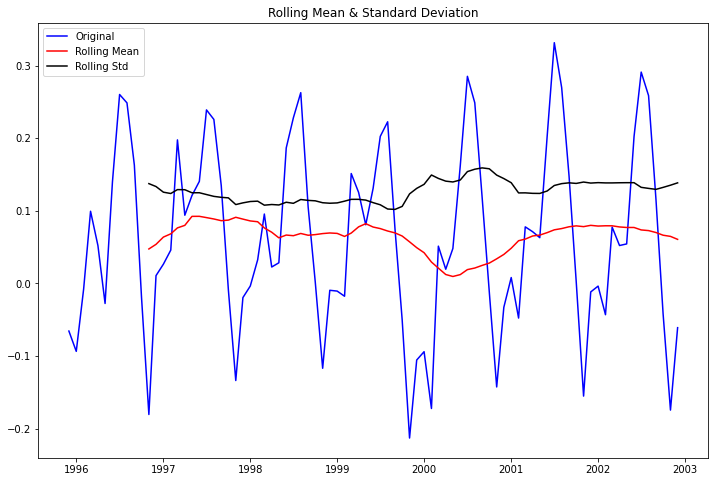

Results of Dickey-Fuller Test:
Test Statistic                 -1.910930
p-value                         0.326937
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [139]:
test_stationarity(datasetLogScaleMinusMovingAverage)

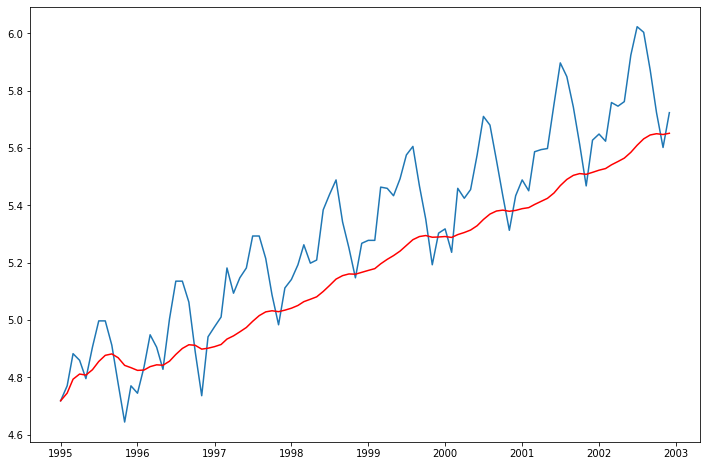

In [140]:
plt.figure(figsize=(12,8))
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')
plt.show()

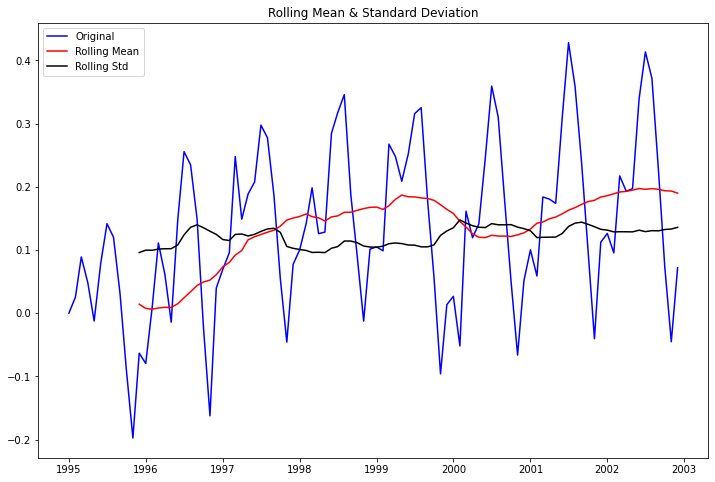

Results of Dickey-Fuller Test:
Test Statistic                 -2.835036
p-value                         0.053441
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [141]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

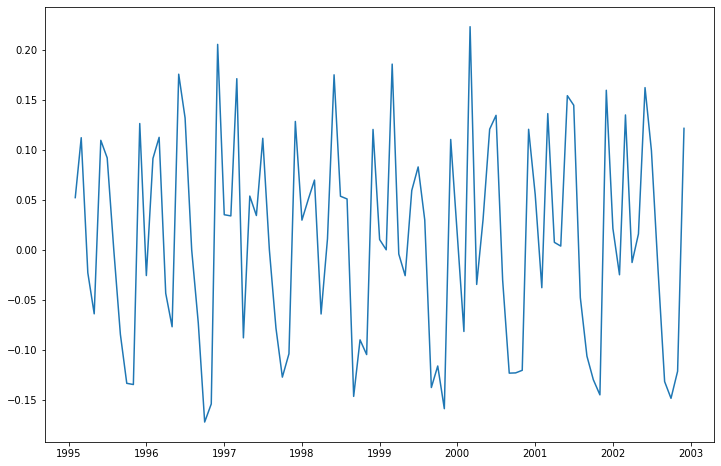

In [142]:
plt.figure(figsize=(12,8))
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)
plt.show()

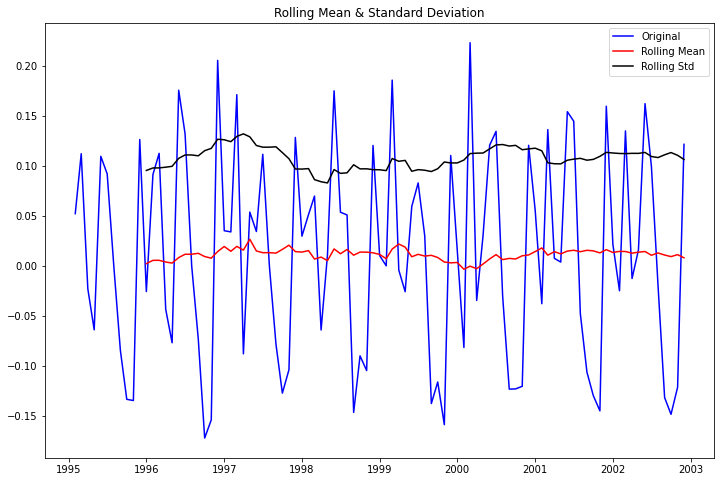

Results of Dickey-Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [143]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


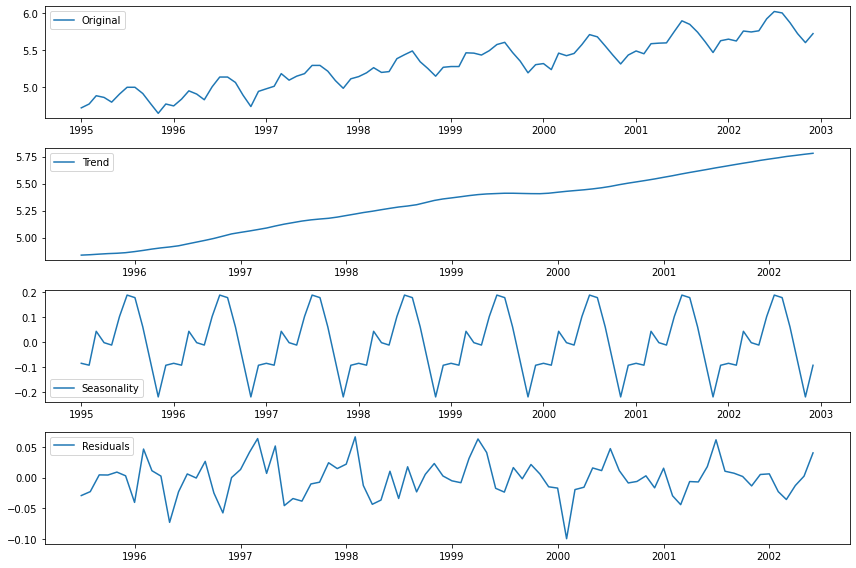

In [146]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

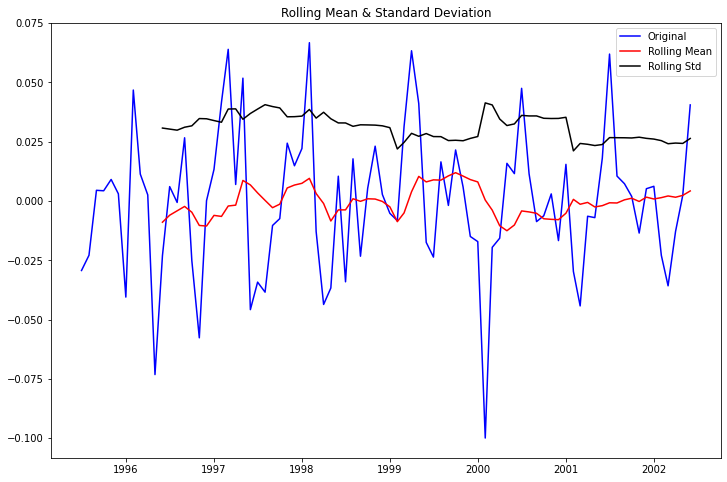

Results of Dickey-Fuller Test:
Test Statistic                -5.907863e+00
p-value                        2.681970e-07
#Lags Used                     3.000000e+00
Number of Observations Used    8.000000e+01
Critical Value (1%)           -3.514869e+00
Critical Value (5%)           -2.898409e+00
Critical Value (10%)          -2.586439e+00
dtype: float64


In [147]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

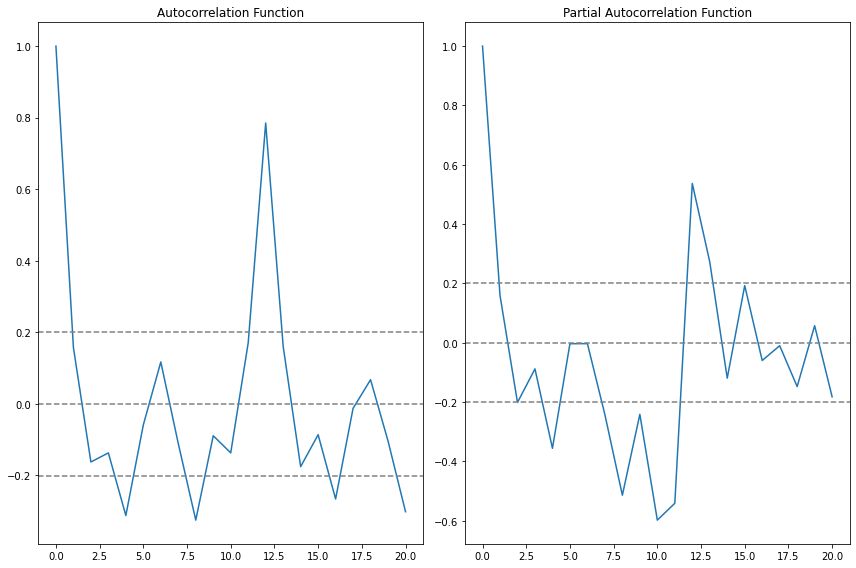

In [148]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')


#Plot ACF: 
plt.figure(figsize=(12,8))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Plotting AR model


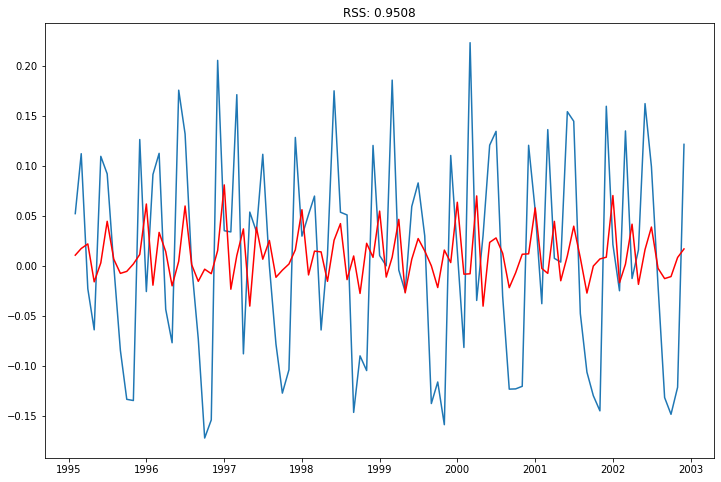

In [149]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
plt.figure(figsize=(12,8))
model = ARIMA(indexedDataset_logScale, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting["Passengers"])**2))
print('Plotting AR model')

Plotting AR model


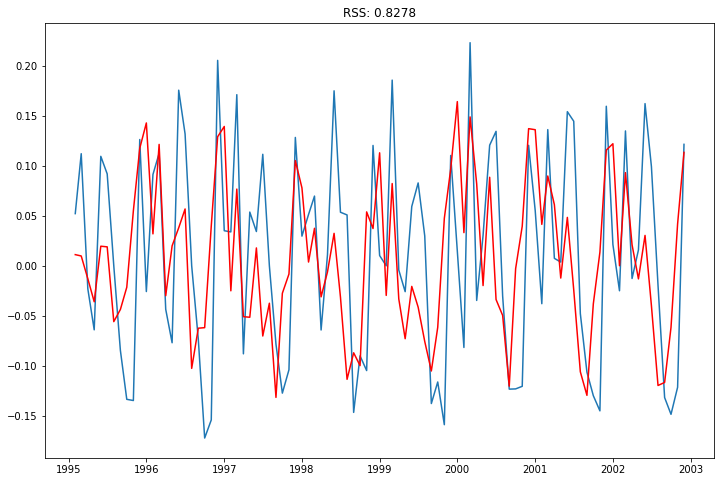

In [150]:
#MA MODEL
plt.figure(figsize=(12,8))
model = ARIMA(indexedDataset_logScale, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting["Passengers"])**2))
print('Plotting AR model')

Text(0.5, 1.0, 'RSS: 0.6931')

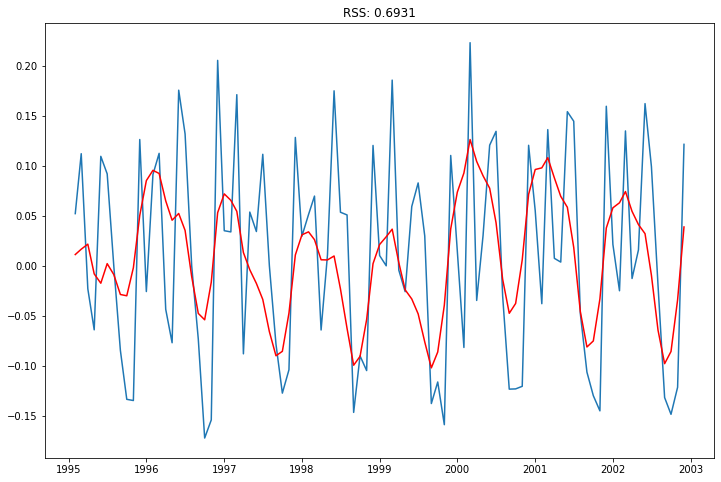

In [151]:
plt.figure(figsize=(12,8))
model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting["Passengers"])**2))

In [152]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
1995-02-01    0.011261
1995-03-01    0.016604
1995-04-01    0.021667
1995-05-01   -0.008099
1995-06-01   -0.017400
dtype: float64


In [153]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Month
1995-02-01    0.011261
1995-03-01    0.027865
1995-04-01    0.049532
1995-05-01    0.041433
1995-06-01    0.024033
dtype: float64


In [156]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Passengers'], index=indexedDataset_logScale['Passengers'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1995-01-01    4.718499
1995-02-01    4.781945
1995-03-01    4.910667
1995-04-01    4.909344
1995-05-01    4.837224
dtype: float64

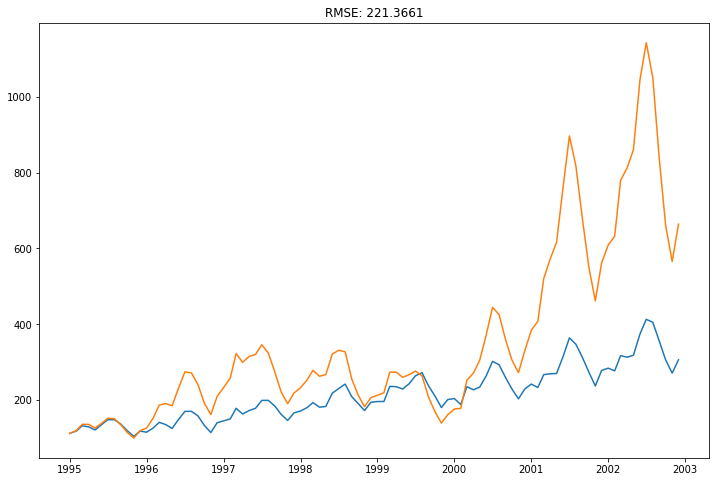

In [157]:
plt.figure(figsize=(12,8))
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-indexedDataset["Passengers"])**2)/len(indexedDataset["Passengers"])))
plt.show()

## **Assignment 2 - CocaCola_Sales**

## **Importing Data**

In [23]:
cocola_sales_data = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
cocola_sales_data


,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


## **Initial Analysis**

In [32]:
cocola_sales_data.shape

(42, 2)

In [33]:
cocola_sales_data.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [34]:
cocola_sales_data.dtypes

Quarter     object
Sales      float64
dtype: object

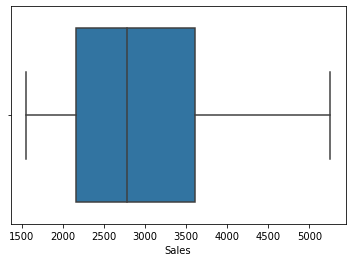

In [51]:
sns.boxplot("Sales",data=cocola_sales_data)
plt.show()

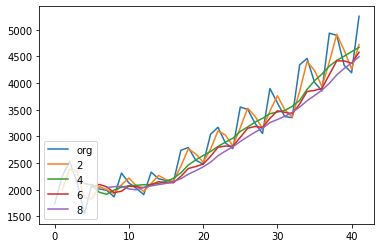

In [26]:
cocola_sales_data.Sales.plot(label="org")   # moving average for the time series to understand better about the trend character in Amtrak
for i in range(2,10,2):
    cocola_sales_data["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)
plt.show()

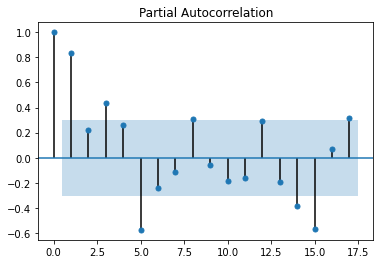

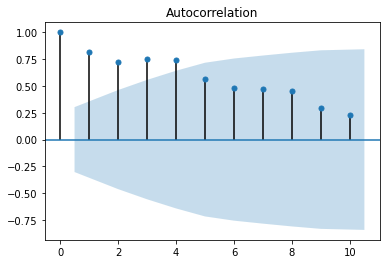

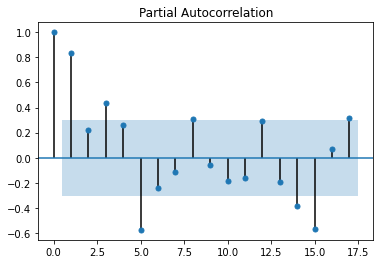

In [31]:
tsa_plots.plot_acf(cocola_sales_data.Sales,lags=10)  # ACF plots and PACF plots on Original data sets 
tsa_plots.plot_pacf(cocola_sales_data.Sales)


## **Model Building**

In [36]:
Train = cocola_sales_data.head(48)
Test =cocola_sales_data.tail(12)

In [38]:
Train

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [39]:
Test

,Quarter,Sales
30,Q3_93,3629.0
31,Q4_93,3373.0
32,Q1_94,3352.0
33,Q2_94,4342.0
34,Q3_94,4461.0
35,Q4_94,4017.0
36,Q1_95,3854.0
37,Q2_95,4936.0
38,Q3_95,4895.0
39,Q4_95,4333.0


## **Model Testing**

In [40]:
# Creating a function to calculate the MAPE value for test data 
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)

In [41]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales)

9.7650842809057

In [42]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales) 


9.786025210610653

In [44]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)

3.12830122302128

In [46]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales) 

2.3591751155132465

## **Model Evaluation**

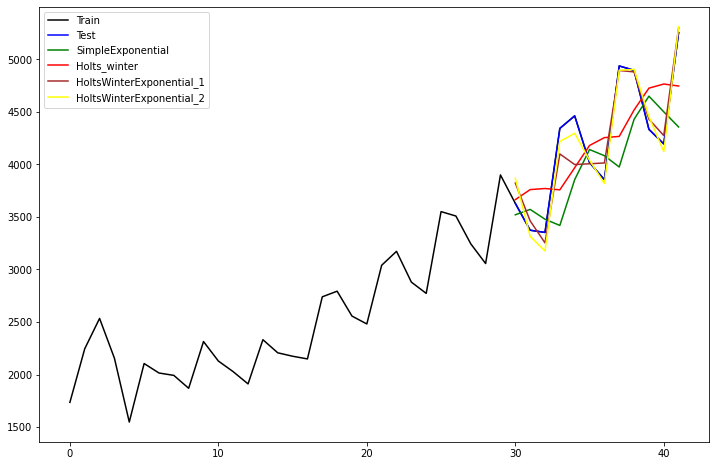

In [49]:
# Visualization of Forecasted values for Test data set using different methods
plt.figure(figsize=(12,8)) 
plt.plot(Train.index, Train["Sales"], label='Train',color="black")
plt.plot(Test.index, Test["Sales"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best')
plt.show()

## **Observation:** 
   Comparing with above four methods **Holts winter exponential smoothing with multiplicative seasonality and additive trend** gives less error and good forecasting trend.